### Tutorial: Companions

What happens when we have multiple planets in a system?

Furthermore, does the Fisher Information picture look different when I pretend one planet isn't there, and can I use this to somehow infer unseen companions? 

#### AU Mic b and c

In [1]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
import pandas as pd
import random
from itertools import chain
import exoplanet
import astropy 
import pymc3
import pymc3_ext
import tinygp
from tinygp import kernels, GaussianProcess
from numpy.linalg import inv, det, solve, cond
from tqdm import tqdm
from astropy.time import Time

import matplotlib.pyplot as plt
import matplotlib

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
#from jax import random

from gaspery import calculate_fi, strategies, utils


1.22.3
1.7.3


In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

path = '/Users/chrislam/Desktop/gaspery/'

In [3]:
def model_multi(t, thetas): 
    """
    Radial velocity model, given timestamps and planetary orbital parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    """
    
    rv_total = 0
    for theta in thetas:
        K, P, T0 = theta[0], theta[1], theta[2]
        arg = (2*np.pi/P)*(t-T0)
    
        rv = -K * np.sin(arg)
        rv_total += rv
    
    return rv_total



In [4]:
### choose start time as date of this writing
start = '2023-03-01T10:00:00'
start = Time(start, format='isot', scale='utc').jd

### target parameters
p = 8.46 # orbital period, days
K = 580 # cm/s
T0 = 2458651.993 # central transit time, in BJD, on 19 June 2019

### correlated noise parameters
Tau = 100/np.sqrt(2) # active region lifetime; days
eta = 0.4/np.sqrt(2) # 0.1, 0.3, 0.58, 0.9 # smoothing parameter
sigma_qp_rv = 47 * 1e2 # modified Jeffreys prior +11, -8 [cm/s]
sigma_wn_rv = 5 * 1e2 # [cm/s]
Prot = 4.86 # rotation period, days

### strategy
offs = []
n_obs = 30
strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)

cadence = 1
strat = strategy.gappy(cadence = cadence)

### Star object and covariance matrix
star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                         Prot = Prot, sigma_qp_rv = sigma_qp_rv)

# populate list of parameters to feed into cov_matrix_jax()
params = star.param_list()

# build covariance matrix, characterized by a correlated noise model of the stellar signal
kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
kernel *= sigma_qp_rv**2 # multiply by scalar

sigma = star.cov_matrix_general(strat, kernel)



In [5]:
### create stellar noise
gp = GaussianProcess(kernel, strat)
sample = gp.sample(jax.random.PRNGKey(4), shape=(1,))

### phase fold
t_phase_folded = strat % p # phase fold support
y_phase_folded = np.array(calculate_fi.model_jax(t_phase_folded, [K, p, T0]))

[[ 6320.067    4326.384   -4741.4624  -4160.9263   7620.4585  -2672.6165
  10431.851    1907.2646  -5759.5977   -312.67004  6603.7485  -1294.7676
  11575.776     460.48242 -5830.2246   2875.847    2367.9482   2273.7346
   9068.99    -2310.7173  -4871.3213   4442.183   -1953.3545   7103.931
   5401.9805  -4424.495   -2587.9087   5464.3257  -2967.357   10965.
   3503.6355  -4760.063     654.03613  4325.2812  -1243.2439  11688.419
   1213.4102  -3928.5076   2408.4592    397.14795  2419.7825   9206.161
  -2484.9475  -2513.4346   3269.6538  -2631.5107   7121.3135   6131.4663
  -4203.332    -104.57385  4030.353   -2900.1033  10532.058    4195.65
  -3263.349    2389.1611   2563.1792  -1283.594   11158.509     766.15137]]


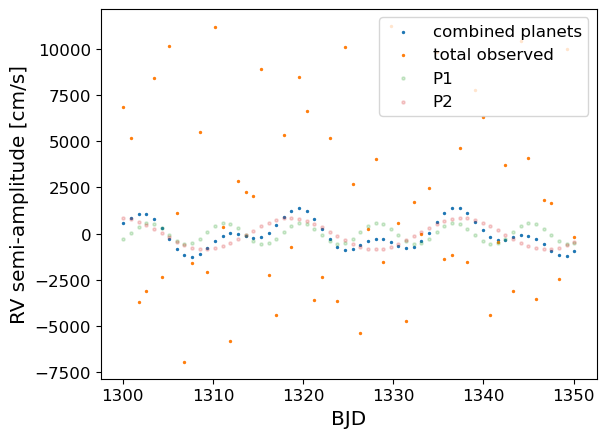

In [6]:
test_t = np.linspace(1300, 1300+50, 60) + np.random.normal(0, 1./24)
test_P1 = 8.46
test_P2 = 18.9
K1 = 580
K2 = 850
T0_1 = 1330.39051
T0_2 = 1342.2223

### create stellar noise
gp = GaussianProcess(kernel, test_t)
sample = gp.sample(jax.random.PRNGKey(4), shape=(1,))
print(sample)

test_thetas = [[K1, test_P1, T0_1], [K2, test_P2, T0_2]]
y = model_multi(test_t, test_thetas)
plt.scatter(test_t, y, s=2, label='combined planets')
plt.scatter(test_t, y + sample, s=2, label='total observed')

plt.scatter(test_t, calculate_fi.model_jax(test_t, [K1, test_P1, T0_1]), s=5, alpha=0.2, label='P1')
plt.scatter(test_t, calculate_fi.model_jax(test_t, [K2, test_P2, T0_2]), s=5, alpha=0.2, label='P2')

plt.xlabel('BJD')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.legend()
plt.show()

Ok, this looks tough to do with, you know, the canonical noisy star. How about a known inactive star with multiple planets? Let's try with LHS 1140 (Lillo-Box+ 2020; Ment+ 2019): https://arxiv.org/pdf/2010.06928.pdf; https://iopscience.iop.org/article/10.3847/1538-3881/aaf1b1)

#### LHS 1140 b and c

We start by laying out our system parameters, using Table B.3 from Lillo-Box+ 2020.

In [7]:
# stellar parameters, used posteriors from Table B.3 in Lillo-Box+ 2020 
Mstar = 0.191 # solar masses
Prot = 131 # Dittmann+ 2017 (https://ui.adsabs.harvard.edu/abs/2017Natur.544..333D/abstract)
sigma_wn_rv = 1.07 # m/s
sigma_qp_rv = 1.16 # m/s
Tau = 135 # days
eta = -1.04

# stellar parameter errors
eta_err1 = 0.16
eta_err2 = -0.15
Prot_err1 = 2.3
Prot_err2 = -2.9
Tau_err1 = 39
Tau_err2 = -24
sigma_qp_rv_err1 = 0.18
sigma_qp_rv_err2 = -0.16
sigma_wn_rv_err1 = 0.2
sigma_wn_rv_err2 = -0.19

# planet parameters: 1 is b; 2 is c; and so on
P1 = 24.7
P2 = 3.78
P3 = 78.9 # planet candidate from their RV observations
m1 = 6.38 # Earth masses
m2 = 1.76
m3 = 4.8
T0_1 = 58399.9303
T0_2 = 58389.29382
T0_3 = 58375.0
K1 = utils.calculate_rv(Mstar, m1, P1)
K2 = utils.calculate_rv(Mstar, m2, P2)
K3 = utils.calculate_rv(Mstar, m3, P3)
print(K1, K2)

# planet parameter errors
m1_err1 = 4.6
m1_err2 = -4.4
m2_err1 = 0.17
m2_err2 = -0.16

4.220764378120578 2.1767980955376456


As usual, we pick an observing strategy to get things started.

In [60]:
### choose start time as date of this writing
start = '2023-03-07T10:00:00'
start = Time(start, format='isot', scale='utc').jd

### strategy
offs = []
n_obs = 100
strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)

cadence = 1
strat = strategy.gappy(cadence = cadence)

We instantiate a Star class object and compute the covariance matrix based on the stellar correlated noise model. 

In [61]:
### Star object and covariance matrix
star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                         Prot = Prot, sigma_qp_rv = sigma_qp_rv)

# populate list of parameters to feed into cov_matrix_jax()
params = star.param_list()

# build covariance matrix, characterized by a correlated noise model of the stellar signal
kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
kernel *= sigma_qp_rv**2 # multiply by scalar

sigma = star.cov_matrix_general(strat, kernel)

That's already all we need to plot the phase curves, so let's do that, after phase folding on the longer planet orbital period.

In [62]:
### create stellar noise
gp = GaussianProcess(kernel, strat)
sample = gp.sample(jax.random.PRNGKey(4), shape=(1,))

### phase fold
t_phase_folded1 = (strat-T0_1) % P1 # phase fold support
t_phase_folded2 = (strat-T0_2) % P1 # phase fold support
t_phase_folded3 = (strat-T0_3) % P1 # phase fold support

y_phase_folded1 = np.array(calculate_fi.model_jax(t_phase_folded1, [K1, P1, T0_1]))
y_phase_folded2 = np.array(calculate_fi.model_jax(t_phase_folded2, [K2, P2, T0_2]))
y_phase_folded3 = np.array(calculate_fi.model_jax(t_phase_folded3, [K3, P3, T0_3]))

In [63]:
"""
plt.plot(strat, np.array(calculate_fi.model_jax(strat, K1, P1, T0_1)), label='LHS 1140b')
plt.scatter(strat, np.array(calculate_fi.model_jax(strat, K2, P2, T0_2)), s=5, label='LHS 1140c')
plt.scatter(strat, np.array(calculate_fi.model_jax(strat, K1, P1, T0_1)) + np.array(calculate_fi.model_jax(strat, K2, P2, T0_2)), 
            label='combined planet signal')
#plt.scatter(t_phase_folded2, sample + y_phase_folded1 + y_phase_folded2, label='observed signal')
plt.xlabel(r'BJD')
plt.ylabel('RV semi-amplitude [m/s]')
plt.legend()
plt.show()
"""

"\nplt.plot(strat, np.array(calculate_fi.model_jax(strat, K1, P1, T0_1)), label='LHS 1140b')\nplt.scatter(strat, np.array(calculate_fi.model_jax(strat, K2, P2, T0_2)), s=5, label='LHS 1140c')\nplt.scatter(strat, np.array(calculate_fi.model_jax(strat, K1, P1, T0_1)) + np.array(calculate_fi.model_jax(strat, K2, P2, T0_2)), \n            label='combined planet signal')\n#plt.scatter(t_phase_folded2, sample + y_phase_folded1 + y_phase_folded2, label='observed signal')\nplt.xlabel(r'BJD')\nplt.ylabel('RV semi-amplitude [m/s]')\nplt.legend()\nplt.show()\n"

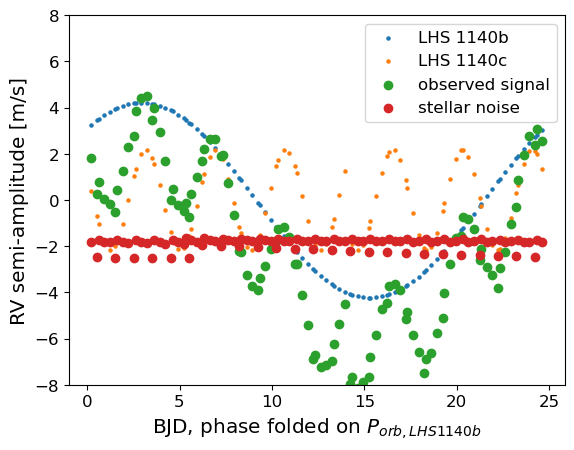

In [64]:
plt.scatter(t_phase_folded1, y_phase_folded1, s=5, label='LHS 1140b')
plt.scatter(t_phase_folded1, y_phase_folded2, s=5, label='LHS 1140c')
#plt.scatter(t_phase_folded1, y_phase_folded1 + y_phase_folded2, label='combined planet signal')
plt.scatter(t_phase_folded1, sample + y_phase_folded1 + y_phase_folded2, label='observed signal')
#plt.scatter(t_phase_folded1, sample + y_phase_folded1 + y_phase_folded2 + y_phase_folded3, label='observed signal')
plt.scatter(t_phase_folded1, sample, label='stellar noise')
plt.xlabel(r'BJD, phase folded on $P_{orb, LHS 1140b}$')
plt.ylabel('RV semi-amplitude [m/s]')
plt.ylim([-8, 8])
plt.legend()
plt.savefig(path+'lhs-1140/phase-curve.png')
plt.show()


Looks like the stellar signal won't be giving us a lot of trouble. This makes sense because LHS 1140 is an inactive star, at ~5 Gyrs old. 

This is what I get when I phase fold on LHS 1140b (the longer period one, confusingly, but also the one that was discovered first). Green dots are what we actually observe. So, we have two scenarios I can immediately test:
- If I know LHS 1140b exists, then how do I infer that LHS 1140c also exists based on the green points, since I think it should look like the blue points? It helps that the Prot and Tau baselines are so long for this star, that the red points, which capture the stellar contribution to the observed signal, don't vary appreciably. So, qualitatively, it seems pretty tough but not impossible to infer LHS 1140c if just b was the prior. 
- Conversely, if I know LHS 1140c exists, then I'd only expect the orange signal, which is very different from the observed, green, signal. So, qualitatively, it seems pretty easy to infer LHS 1140b if just c was the prior. 

Quantitatively, then, I could calculate sigma_K for b assuming c doesn't exist and then again assuming that it does. And then the same for c (assuming b exists, and then assuming b doesn't). 

**Note!** I need to first put the planet parameters into a single, flattened list to feed into the Fisher Info calculator. 

In [65]:
jax.config.update("jax_enable_x64", True)

theta1 = [K1, P1, T0_1]
theta2 = [K2, P2, T0_2]
thetas = [theta1, theta2]
flat_theta = list(chain.from_iterable(thetas)) # flatten list of lists

args = np.array(strat), sigma, jnp.array(flat_theta, dtype=float)
fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
inv_fim = inv(fim)
sigma_k1 = np.sqrt(inv_fim)[0][0]
sigma_k2 = np.sqrt(inv_fim)[3][3]

fi_k = fim[0][0]
print(sigma_k1, sigma_k2)

0.15138396350529543 0.15135471574836828


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9262/1202982616.py:11: RuntimeWarning: invalid value encountered in sqrt
  sigma_k1 = np.sqrt(inv_fim)[0][0]
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9262/1202982616.py:12: RuntimeWarning: invalid value encountered in sqrt
  sigma_k2 = np.sqrt(inv_fim)[3][3]


So, that was the sigma_K for both planets, if we assume both exist. 

In [66]:
args = np.array(strat), sigma, jnp.array(theta1, dtype=float)
fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

In [67]:
inv_fim = inv(fim)
sigma_k11 = np.sqrt(inv_fim)[0][0]
print(sigma_k11)

0.15133589320173088


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9262/2209798962.py:2: RuntimeWarning: invalid value encountered in sqrt
  sigma_k11 = np.sqrt(inv_fim)[0][0]


This is sigma_K on LHS 1140b if we assume c doesn't exist.

In [68]:
args = np.array(strat), sigma, jnp.array(theta2, dtype=float)
fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
inv_fim = inv(fim)
sigma_k22 = np.sqrt(inv_fim)[0][0]
print(sigma_k22)

0.1512572882323222


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9262/3405677529.py:4: RuntimeWarning: invalid value encountered in sqrt
  sigma_k22 = np.sqrt(inv_fim)[0][0]


This is sigma_K on LHS 1140c if we assume b doesn't exist.

In [69]:
print(sigma_k11 - sigma_k1)
print(sigma_k22 - sigma_k2)

-4.807030356454578e-05
-9.742751604607802e-05


This means that we overestimate sigma_K when we assume there's no companion. Makes sense so far. It also means that we overestimate sigma_K by (very slightly) more when we assume b has no companion, than when we assume c has no companion. This also tracks with the qualitative picture we see from the phase curve above. 

#### Testing putative systems

Each observing strategy paired with a putative companion yields an expected value for sigma_K, `<sigma_K>`. So if I try different putative systems, I should have a colormap along {P, K} of different `<sigma_K>`. Then, when a user gets their data back and computes sigma_K, they can compute the probability that a certain system is compatible with the RV data.

Since assuming planet c doesn't exist has a bigger effect on the expected value of sigma_K, let's start by assuming we know only about planet b. To simplify things, let's also say the various planet c's that we try all have the same T0 as the real planet c's T0. 

In [77]:
p_grid = np.linspace(1, 100, 100)
k_grid = np.linspace(1, 10, 40)

sigma_ks = np.ones(len(p_grid)*len(k_grid)).reshape((len(p_grid),len(k_grid)))
sigma_k_diffs = np.ones(len(p_grid)*len(k_grid)).reshape((len(p_grid),len(k_grid)))

for enum_p, p in enumerate(tqdm(p_grid)):
    for enum_k, K in enumerate(k_grid):
        
        theta = [K1, P1, T0_1, K2, P2, T0_2]
        
        # tack on a new planet of varying P, K
        theta.append(K)
        theta.append(p)
        theta.append(T0_3)
        
        # populate arguments for Fisher Info calculator
        args = np.array(strat), sigma, jnp.array(theta, dtype=float)

        # calculate FI
        fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

        # invert FI matrix
        try:
            inv_fim = inv(fim)

            # top left element of matrix corresponds with RV semi-amplitude, K
            sigma_k1 = np.sqrt(inv_fim)[0][0]
            sigma_k2 = np.sqrt(inv_fim)[3][3]
            sigma_k3 = np.sqrt(inv_fim)[6][6]
            
            sigma_ks[enum_p][enum_k] = sigma_k1 + sigma_k2 + sigma_k3
            sigma_k_diffs[enum_p][enum_k] = sigma_wn_rv + sigma_qp_rv + sigma_k1 + sigma_k2 + sigma_k3 - observed_sigma_k

        except:
            sigma_ks[enum_p][enum_k] = np.nan
            sigma_k_diffs[enum_p][enum_k] = np.nan

  0%|                                                                         | 0/100 [00:00<?, ?it/s]/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9262/2791999025.py:28: RuntimeWarning: invalid value encountered in sqrt
  sigma_k1 = np.sqrt(inv_fim)[0][0]
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9262/2791999025.py:29: RuntimeWarning: invalid value encountered in sqrt
  sigma_k2 = np.sqrt(inv_fim)[3][3]
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9262/2791999025.py:30: RuntimeWarning: invalid value encountered in sqrt
  sigma_k3 = np.sqrt(inv_fim)[6][6]
100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.19it/s]


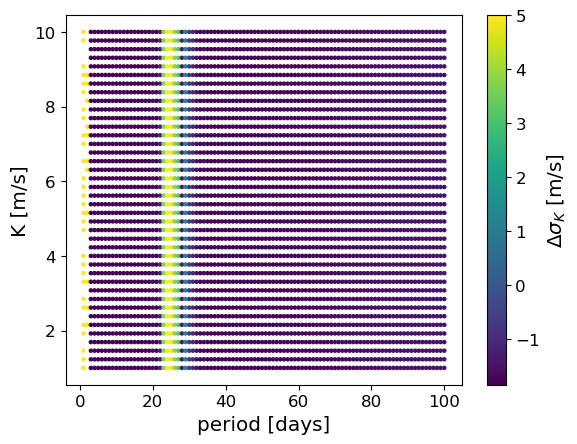

In [78]:
x, y = np.meshgrid(k_grid, p_grid)
plt.scatter(y, x, c=sigma_k_diffs, s=5, vmax=5) # vmin=5, vmax=35, norm=matplotlib.colors.LogNorm()

cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$\Delta \sigma_K$ [m/s]')
plt.ylabel("K [m/s]")
plt.xlabel("period [days]")
#plt.title(r"K = " + f"{K} m/s; " + "$P_{orb}$ = " + f"{p} days")
plt.savefig(path + f"lhs-1140/third-candidate.png", format="png")
plt.show()

In [79]:
P2

3.78

This map shows that there are certain period ranges where the total expected values of sigma_K summed across the three planets deviates from the observed sigma_K in different ways at different period ranges. Positive delta sigma_K means we have over-estimated the expected noise (ie. the planet is in a position that causes me to lose a lot of information). Negative delta sigma_K means we have under-estimated the noise (ie. the planet is in a position such that I'm still missing some contribution).

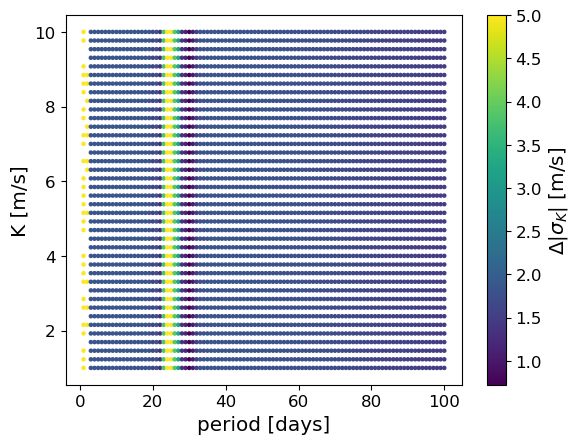

In [80]:
x, y = np.meshgrid(k_grid, p_grid)
plt.scatter(y, x, c=np.abs(sigma_k_diffs), s=5, vmax=5) # vmin=5, vmax=35, norm=matplotlib.colors.LogNorm()

cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$\Delta |\sigma_K|$ [m/s]')
plt.ylabel("K [m/s]")
plt.xlabel("period [days]")
#plt.title(r"K = " + f"{K} m/s; " + "$P_{orb}$ = " + f"{p} days")
#plt.savefig(path + f"lhs-1140/third-candidate.png", format="png")
plt.show()

How about in 1D since without errors, this has no dependence on K.

In [81]:
p_grid = np.linspace(1, 100, 100)

sigma_ks = []
sigma_k_diffs = []

for enum_p, p in enumerate(tqdm(p_grid)):
        
        theta = [K1, P1, T0_1, K2, P2, T0_2]
        
        # tack on a new planet of varying P, K
        theta.append(K3)
        theta.append(p)
        theta.append(T0_2)
        
        # flatten theta 
        #theta = list(chain.from_iterable(theta))
        
        # populate arguments for Fisher Info calculator
        args = np.array(strat), sigma, jnp.array(theta, dtype=float)

        # calculate FI
        fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

        # invert FI matrix
        try:
            inv_fim = inv(fim)

            # top left element of matrix corresponds with RV semi-amplitude, K
            sigma_k1 = np.sqrt(inv_fim)[0][0]
            sigma_k2 = np.sqrt(inv_fim)[3][3]
            sigma_k3 = np.sqrt(inv_fim)[6][6]
            
            sigma_ks.append(sigma_wn_rv + sigma_qp_rv + sigma_k1 + sigma_k2 + sigma_k3)
            sigma_k_diffs.append(sigma_wn_rv + sigma_qp_rv + sigma_k1 + sigma_k2 + sigma_k3 - observed_sigma_k)

        except:
            sigma_ks.append(np.nan)
            sigma_k_diffs.append(np.nan)

  0%|                                                                         | 0/100 [00:00<?, ?it/s]/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9262/996539778.py:29: RuntimeWarning: invalid value encountered in sqrt
  sigma_k1 = np.sqrt(inv_fim)[0][0]
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9262/996539778.py:30: RuntimeWarning: invalid value encountered in sqrt
  sigma_k2 = np.sqrt(inv_fim)[3][3]
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9262/996539778.py:31: RuntimeWarning: invalid value encountered in sqrt
  sigma_k3 = np.sqrt(inv_fim)[6][6]
100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 509.37it/s]


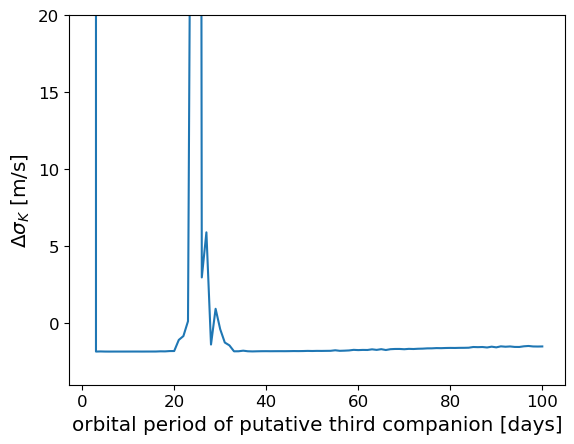

In [82]:
plt.plot(p_grid, sigma_k_diffs)
plt.ylim([-4, 20])
plt.ylabel(r'$\Delta \sigma_K$ [m/s]')
plt.xlabel('orbital period of putative third companion [days]')
plt.show()

Leo Paredes from NEID/UAriz: periodogram and false alarm probability to constrain the orbit. 

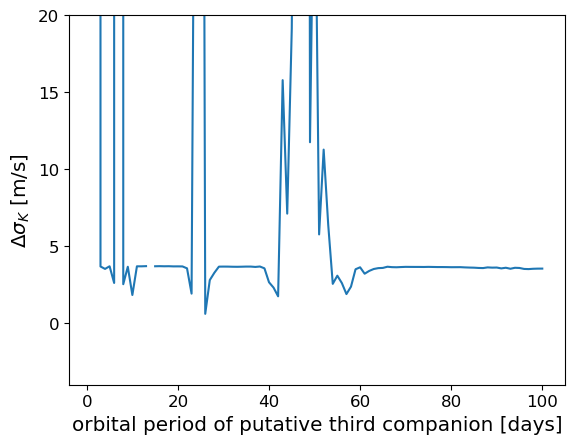

In [41]:
plt.plot(p_grid, np.abs(sigma_k_diffs))
plt.ylim([-4, 20])
plt.ylabel(r'$\Delta \sigma_K$ [m/s]')
plt.xlabel('orbital period of putative third companion [days]')
plt.show()

In [133]:
#theta = [K1, P1, T0_1, K2, P2, T0_2, K3, P3, T0_3]
K2 = 2.177
#K2 = 100
theta = [K1, P1, T0_1, K2, P2, T0_2]

# populate arguments for Fisher Info calculator
args = np.array(strat), sigma, jnp.array(theta, dtype=float)

# calculate FI
fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

# invert FI matrix
inv_fim = inv(fim)

# top left element of matrix corresponds with RV semi-amplitude, K
print(np.sqrt(inv_fim)[0][0])
print(np.sqrt(inv_fim)[3][3])
#print(np.sqrt(inv_fim)[6][6])

0.27798828761308614
0.28169952798862324


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_13516/4145169225.py:16: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(inv_fim)[0][0])
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_13516/4145169225.py:17: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(inv_fim)[3][3])


In [135]:
sigma.shape

(30, 30)

What confuses me is this: this is saying that I underestimate the uncertainty on K if I assume most orbital periods for the third planet (unless I park the third planet where the second planet, which is a nonsensical case). So far so good. But let's say there's a third planet that's really big at 60 days, vs one that's really small. Surely that should have an effect on the expected sigma K for planet b. Oh wait, it should, mathematically. 

So what gives? 

Do I need to introduce the trace term of Fisher Information sooner than I'd expected? 

In [62]:
theta = [K1, P1, T0_1, K2, P2, T0_2]

# populate arguments for Fisher Info calculator
args = np.array(strat), sigma, jnp.array(theta, dtype=float)

# calculate FI
fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

# invert FI matrix
inv_fim = inv(fim)

# top left element of matrix corresponds with RV semi-amplitude, K
print(np.sqrt(inv_fim)[0][0])
print(np.sqrt(inv_fim)[3][3])

0.27671353333780946
0.2770507339718181


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_13516/918822528.py:13: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(inv_fim)[0][0])
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_13516/918822528.py:14: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(inv_fim)[3][3])


In [22]:
@jax.jit
def jax_fim(t, sigma, theta): 
    """
    Calculate the generalized Fisher Information Matrix using JAX Jacobian.
    Generalizable to arbitrary parameters.
    Now, with second term for correlated noise. 
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; must be flattened list if multiple planets; np.array
        - K: RV semi-amplitude [cm/s]
        - P: planet period [days]
        - T0: mean transit time [day]

    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    def inner(params):
        return model_jax_multi(t, params)
    
    # add jitter
    sigma += 1e-6 

    # take inverse of covariance matrix
    factor = jnp.linalg.solve(sigma, jnp.identity(len(sigma))) 
    
    # calculate the Jacobian   
    J = jax.jacobian(inner)(theta)

    return J.T @ factor @ J

def model_jax_multi(t, theta): 

    """
    JAX-enabled radial velocity model for multi-planet system
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - thetas: list of lists of [K, P, T0], where:
        - K: RV semi-amplitude [cm/s]
        - P: planet period [days]
        - T0: mean transit time [day]

    Returns: 
    - rv_total: np.array of RV semi-amplitudes

    """
    
    K1, P1, T0_1, K2, P2, T0_2 = theta[0], theta[1], theta[2], theta[3], theta[4], theta[5]
    
    arg1 = (2*jnp.pi/P1)*(t-T0_1)
    rv1 = -K1 * jnp.sin(arg1)
    
    arg2 = (2*jnp.pi/P2)*(t-T0_2)
    rv2 = -K2 * jnp.sin(arg2)

    rv_total = rv1 + rv2
    
    return rv_total

In [27]:
fim = jax_fim(*args).block_until_ready()

# invert FI matrix
inv_fim = inv(fim)

# top left element of matrix corresponds with RV semi-amplitude, K
print(np.sqrt(inv_fim)[0][0])
print(np.sqrt(inv_fim)[3][3])



1.1614515016641211
7.502356512441708


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_13516/1806235654.py:7: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(inv_fim)[0][0])
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_13516/1806235654.py:8: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(inv_fim)[3][3])


#### Constraining the period of hypothetical LHS 1140d

Let's say RV measurements suggest the existence of a third planet. What is the minimum observations needed to confirm its period to within 10% precision? Or, what would be the best observing strategy to pin down its period? 

In [89]:
n_obs = 30

In [90]:
on_grid = np.linspace(1, 15, 15)
off_grid = np.linspace(0, 15, 16)
sigma_ks = np.ones(len(on_grid)*len(off_grid)).reshape((len(on_grid),len(off_grid)))
fi_ks = np.ones(len(on_grid)*len(off_grid)).reshape((len(on_grid),len(off_grid)))
baseline_tol = 1000 #116 # observing semester is 3/30/23 through 7/23/23, inclusive

theta = [K1, P1, T0_1, K2, P2, T0_2, K3, P3, T0_3]

for enum_on, on in enumerate(tqdm(on_grid)):
    for enum_off, off in enumerate(off_grid):
    
        on, off = int(on), int(off)
        
        # build strategy time series  
        strategy = strategies.Strategy(n_obs = n_obs, cadence=1, start = start, offs=offs, dropout=0.)
        strat = np.array(strategy.on_vs_off(on=on, off=off, twice_flag=False))
        
        # if strategy is longer than baseline tolerance, don't bother with it
        if strat[-1] - strat[0] > baseline_tol:
            sigma_ks[enum_on][enum_off] = np.nan
            fi_ks[enum_on][enum_off] = np.nan
        
        else:
            # calculate covariance matrix
            sigma = star.cov_matrix_general(strat, kernel)

            # populate arguments for Fisher Info calculator
            args = np.array(strat), sigma, jnp.array(theta, dtype=float)

            # calculate FI
            fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
            fi_ks[enum_on][enum_off] = fim[6][6]

            # invert FI matrix
            inv_fim = inv(fim)

            # top left element of matrix corresponds with RV semi-amplitude, K
            sigma_k = np.sqrt(inv_fim)[6][6]

            #print(f"sigma K for {m} Earth mass: ", sigma_k, " cm/s")
            #print(f"sigma K/K ratio for {m} Earth mass: ", sigma_k/K)

            sigma_ks[enum_on][enum_off] = sigma_k

  0%|                                                                          | 0/15 [00:00<?, ?it/s]/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9262/1173199581.py:38: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[6][6]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 11.85it/s]


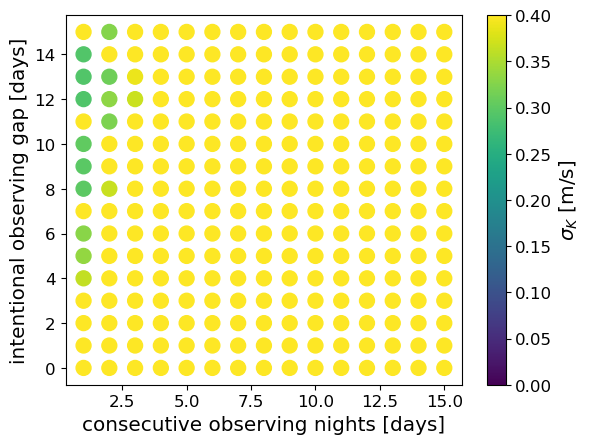

In [96]:
x, y = np.meshgrid(off_grid, on_grid)
#plt.scatter(y, x, c=fi_ks, s=5, norm=matplotlib.colors.LogNorm()) # vmin=1e2, vmax=3e4
#plt.scatter(y, x, c=sigma_ks, s=10, norm=matplotlib.colors.LogNorm(vmin=5, vmax=70)) # vmin=5, vmax=35
plt.scatter(y, x, c=sigma_ks, s=115, vmin=0, vmax=0.4)

cbar = plt.colorbar()
#cbar.ax.set_ylabel(r'$\sqrt{FI_K}$')
cbar.ax.set_ylabel(r'$\sigma_K$ [m/s]')
#cbar.ax.set_ylabel(r'$\sigma_P$ [days]')
plt.ylabel("intentional observing gap [days]")
plt.xlabel("consecutive observing nights [days]")
#plt.yscale('log')
#plt.title(r"$P_{rot}$ = " + f"{Prot} days; " + "$P_{orb}$ = " + f"{p} days")
plt.show()

In [87]:
K3

2.156179853847452

In [102]:
strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)
strat = np.array(strategy.on_vs_off(on=1, off=4, twice_flag=False))

# calculate covariance matrix
sigma = star.cov_matrix_general(strat, kernel)

# populate arguments for Fisher Info calculator
args = np.array(strat), sigma, jnp.array(theta, dtype=float)

# calculate FI
fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

# invert FI matrix
inv_fim = inv(fim)

# top left element of matrix corresponds with RV semi-amplitude, K
sigma_k = np.sqrt(inv_fim)[6][6]
print(K3/sigma_k)

5.9281122690977055


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9262/3315384551.py:17: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[6][6]


In [110]:
P3

78.9

So, I guess a strategy like observing once a week can get us our sigma_P goal. 

#### LHS 1140d

In [18]:
### observed sigma K
rv_data = pd.read_csv(path+'tutorials/lhs-1140.csv', delimiter='|')
observed_sigma_k = np.std(rv_data.RV)*1000
print(observed_sigma_k)

4.531396609169351


In [22]:
### expected value of sigma K on planet b and c, given two-planet system
theta = [K1, P1, T0_1, K2, P2, T0_2]

# populate arguments for Fisher Info calculator
args = np.array(strat), sigma, jnp.array(theta, dtype=float)

# calculate FI
fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

# invert FI matrix
inv_fim = inv(fim)

# top left element of matrix corresponds with RV semi-amplitude, K
sigma_k = np.sqrt(inv_fim)[0][0]
print("sigma_K on planet b, given two planets: ", sigma_k)
sigma_k = np.sqrt(inv_fim)[3][3]
print("sigma_K on planet c, given two planets: ", sigma_k)

sigma_K on planet b, given two planets:  0.2769924608545362
sigma_K on planet c, given two planets:  0.27705585571735863


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9262/1359663848.py:14: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9262/1359663848.py:16: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[3][3]


In [24]:
### expected value of sigma K on planet b and c, given three-planet system
theta = [K1, P1, T0_1, K2, P2, T0_2]
theta.append(K3)
theta.append(P3)
theta.append(T0_3)

# populate arguments for Fisher Info calculator
args = np.array(strat), sigma, jnp.array(theta, dtype=float)

# calculate FI
fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

# invert FI matrix
inv_fim = inv(fim)

# top left element of matrix corresponds with RV semi-amplitude, K
sigma_k1 = np.sqrt(inv_fim)[0][0]
print("sigma_K on planet b, given three planets: ", sigma_k1)
sigma_k2 = np.sqrt(inv_fim)[3][3]
print("sigma_K on planet c, given three planets: ", sigma_k2)
sigma_k3 = np.sqrt(inv_fim)[6][6]
print("sigma_K on planet d, given three planets: ", sigma_k3)

sigma_K on planet b, given three planets:  2.9150002628914993
sigma_K on planet c, given three planets:  0.28348014794118104
sigma_K on planet d, given three planets:  1.6760978120041323


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9262/1207366461.py:17: RuntimeWarning: invalid value encountered in sqrt
  sigma_k1 = np.sqrt(inv_fim)[0][0]
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9262/1207366461.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_k2 = np.sqrt(inv_fim)[3][3]
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_9262/1207366461.py:21: RuntimeWarning: invalid value encountered in sqrt
  sigma_k3 = np.sqrt(inv_fim)[6][6]


In [26]:
sigma_k1 + sigma_k2 + sigma_k3 - observed_sigma_k

0.34318161366746125

Ok, now let's try various combinations of {K, P} and see what get us the closest to observed sigma_K when we sum expected values on sigma_Ks for the three planets.